In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Import raw EEG data
Imports the `extract.p` file generated by the [extraction notebook](eeg-data/data-extract.ipynb).

Shapes:
- X: `(subject, trials, n_timepoints, channels)`
- y: `(subject, trials)`

In [2]:
import pickle

with open('eeg-data/extract.p', 'rb') as f:
    EEG_raw, y = pickle.load(f)

for i, subj in enumerate(EEG_raw):
    n_trials, n_t, n_ch = subj.shape
    print(f"Subject {i+1}: {n_trials} trials, {n_t} samples, {n_ch} channels")

Subject 1: 1236 trials, 1536 samples, 16 channels
Subject 2: 1960 trials, 1536 samples, 16 channels
Subject 3: 434 trials, 1536 samples, 16 channels
Subject 4: 1464 trials, 1536 samples, 16 channels
Subject 5: 494 trials, 1536 samples, 16 channels
Subject 6: 1126 trials, 1536 samples, 16 channels


Since the number of trials is not equal between the subjects, downsample trials per subject to the minimum by random selection (fixed seed)

In [3]:
def resize_trials(X, y, seed=42):
    rng = np.random.default_rng(seed)
    min_trials = min(s.shape[0] for s in X)
    X_resized, y_resized = [], []
    for subj_X, subj_y in zip(X, y):
        n = subj_X.shape[0]
        idx = np.arange(min_trials) if n == min_trials else rng.choice(n, size=min_trials, replace=False)
        X_resized.append(subj_X[idx])
        y_resized.append(subj_y[idx])
    return np.stack(X_resized), np.stack(y_resized)

EEG_raw, y = resize_trials(EEG_raw, y)
print("After trial resize:")
for i, subj in enumerate(EEG_raw):
    n_trials, n_t, n_ch = subj.shape
    print(f"Subject {i+1}: {n_trials} trials, {n_t} samples, {n_ch} channels")
print("...as a single numpy array of shape:", EEG_raw.shape)

After trial resize:
Subject 1: 434 trials, 1536 samples, 16 channels
Subject 2: 434 trials, 1536 samples, 16 channels
Subject 3: 434 trials, 1536 samples, 16 channels
Subject 4: 434 trials, 1536 samples, 16 channels
Subject 5: 434 trials, 1536 samples, 16 channels
Subject 6: 434 trials, 1536 samples, 16 channels
...as a single numpy array of shape: (6, 434, 1536, 16)


In [4]:
fs = 256
mi_duration = 6
n_subjects, n_trials, n_samples, n_channels = EEG_raw.shape
assert all(subj.shape[1] == fs * mi_duration for subj in EEG_raw), f"Expected {fs * mi_duration} samples per trial"

# Plot raw EEG data
Most frequency contribution happens in the range 2-30Hz and drops drastically around 41Hz

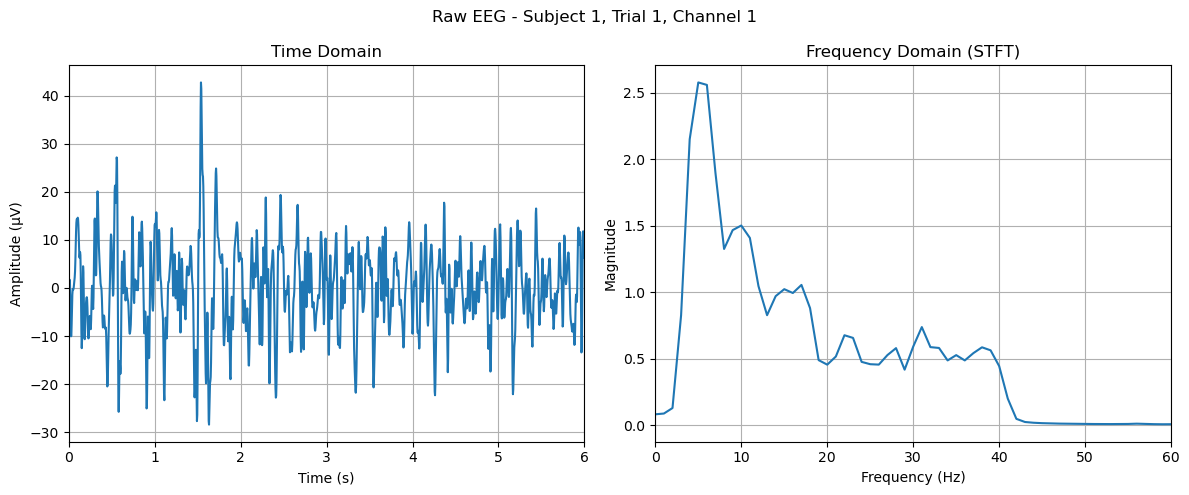

In [5]:
# Plots a single EEG channel in time and frequency domains
def plot_EEG_channel(eeg, fs, title):  
    t = np.arange(len(eeg)) / fs

    plt.figure(figsize=(12, 5))

    # Time domain plot
    plt.subplot(1, 2, 1)
    plt.plot(t, eeg)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.title('Time Domain')
    plt.xlim(0, len(eeg)/fs)
    plt.grid(True)

    # Frequency domain: STFT
    freqs, t, Zxx = signal.stft(eeg, fs=fs)
    magnitude = np.mean(np.abs(Zxx), axis=1)
    plt.subplot(1, 2, 2)
    plt.plot(freqs, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title('Frequency Domain (STFT)')
    plt.xlim(0, 60)
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

plot_EEG_channel(EEG_raw[0, 0, :, 0], fs, "Raw EEG - Subject 1, Trial 1, Channel 1") # example: subject 1, trial 1, channel 1

# Static filters
1. Notch Filter: Removes 50 Hz power line noise using IIR notch filter
2. Band-pass Filter: 8-30 Hz using Chebyshev Type II filter

In [6]:
# Notch filter to remove 50 Hz power line noise
b_notch, a_notch = signal.iirnotch(50, Q=30, fs=fs)    # Q factor determines the bandwidth of the notch filter

# Band-pass filter between 8-30 Hz
b_bp, a_bp = signal.cheby2(
    N=6,                        # Higher order = sharper cutoff
    rs=40,                      # Stopband attenuation in dB -> Suppress everything outside the passband by at least rs dB
    Wn=[8/(fs/2), 30/(fs/2)],   # Normalized cutoff frequencies (Nyquist frequency = fs/2)
    btype='bandpass'
)

# Apply the filters
EEG_notched = signal.filtfilt(b_notch, a_notch, EEG_raw, axis=2)
EEG_bp = signal.filtfilt(b_bp, a_bp, EEG_raw, axis=2)
EEG_filtered = signal.filtfilt(b_bp, a_bp, EEG_notched, axis=2) # <--- Use this from now on

# Plot filtering effect
As expected, the notch filter doesn't have a noticeable effect

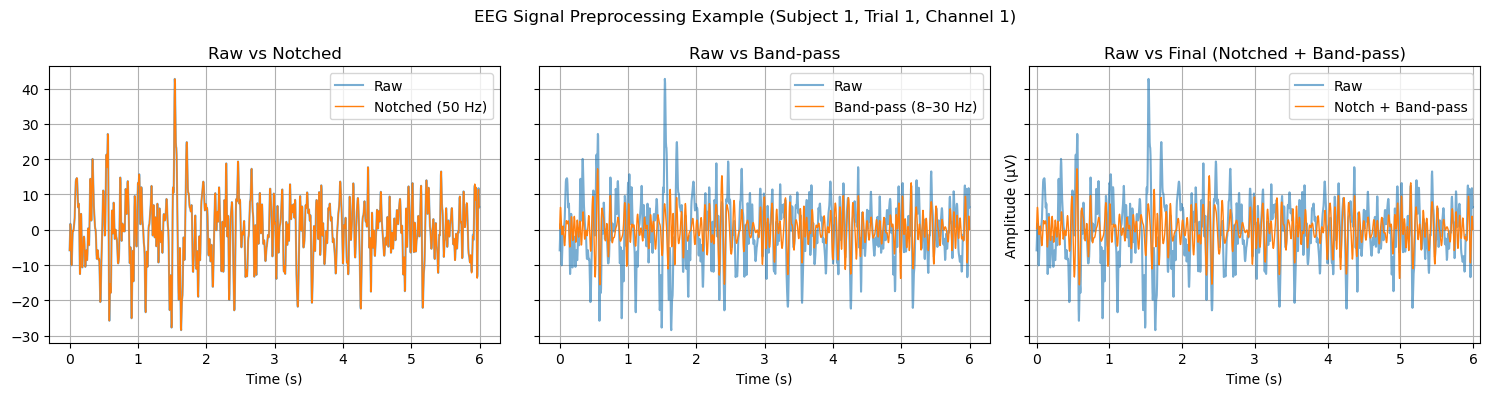

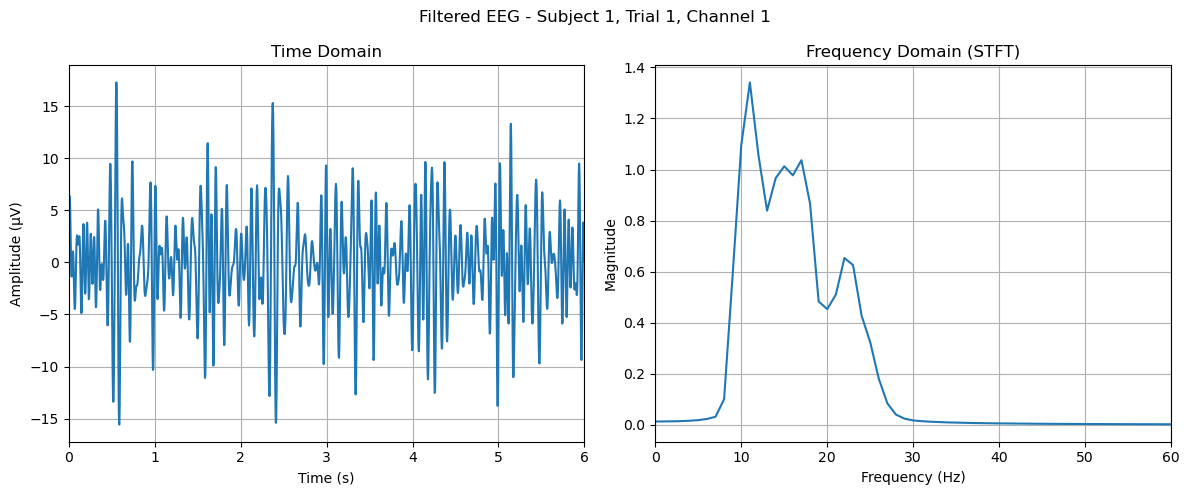

In [7]:
mask = np.zeros(EEG_raw.shape, dtype=bool)
mask[0, 0, :, 0] = True  # example: Subject 1, Trial 1, Channel 1

fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
t = np.arange(EEG_raw.shape[2]) / fs

axs[0].plot(t, EEG_raw[mask], label="Raw", alpha=0.6)
axs[0].plot(t, EEG_notched[mask], label="Notched (50 Hz)", linewidth=1)
axs[0].set_title("Raw vs Notched")
axs[0].set_xlabel("Time (s)")
axs[0].grid(True)
axs[0].legend()

axs[1].plot(t, EEG_raw[mask], label="Raw", alpha=0.6)
axs[1].plot(t, EEG_bp[mask], label="Band-pass (8–30 Hz)", linewidth=1)
axs[1].set_title("Raw vs Band-pass")
axs[1].set_xlabel("Time (s)")
axs[1].grid(True)
axs[1].legend()

axs[2].plot(t, EEG_raw[mask], label="Raw", alpha=0.6)
axs[2].plot(t, EEG_filtered[mask], label="Notch + Band-pass", linewidth=1)
axs[2].set_title("Raw vs Final (Notched + Band-pass)")
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Amplitude (µV)")
axs[2].grid(True)
axs[2].legend()

plt.xlim(-.1, t[-1] + .1)
plt.suptitle("EEG Signal Preprocessing Example (Subject 1, Trial 1, Channel 1)")
plt.tight_layout()
plt.show()
plot_EEG_channel(EEG_filtered[0, 0, :, 0], fs, "Filtered EEG - Subject 1, Trial 1, Channel 1")

# Spatial filters 

## PCA
It looks for linear channel combinations that account for all rows' maximal variances.

In terms of EEG terminology: variance is computed over time points and trials, pooled across subjects; PCA is learning spatial patterns, weighted sums of electrodes

Variance that indicates "this subject has stronger signals" is suppressed as a result of per-subject normalization.

Thus, PCA is recording: A spatial covariance structure that holds true for all subjects Over time, dominant channel co-activations

In [8]:
# Per-subject z-score normalization
X = []
for s in range(n_subjects):
    part = EEG_filtered[s].reshape(-1, n_channels)
    X.append((part - part.mean(axis=0)) / part.std(axis=0))
X = np.vstack(X)

In [9]:
from sklearn.decomposition import PCA

threshold_expl_var = 0.95
pca = PCA().fit(X)
X_pca = pca.transform(X)

# Pick number of components to retain 95% variance
cumul_expl_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.searchsorted(cumul_expl_var, threshold_expl_var) + 1
X_pca = X_pca[:, :n_components]
print(f"Number of components selected in order to retain {threshold_expl_var*100}% variance -> {n_components}")

# Reshape back to (n_subjects, n_trials, n_samples, n_components)
X_pca = X_pca.reshape(n_subjects, n_trials, n_samples, n_components) # shape: (n_subjects, n_trials, n_samples, n_components)
assert X_pca.shape[-1] < n_channels, "PCA did not reduce dimensionality as expected!"
X_pca.shape

Number of components selected in order to retain 95.0% variance -> 6


(6, 434, 1536, 6)

## Plot PCA filtering effect
Since the goal is just dimensionality reduction, we expected the plots to be similar as before.

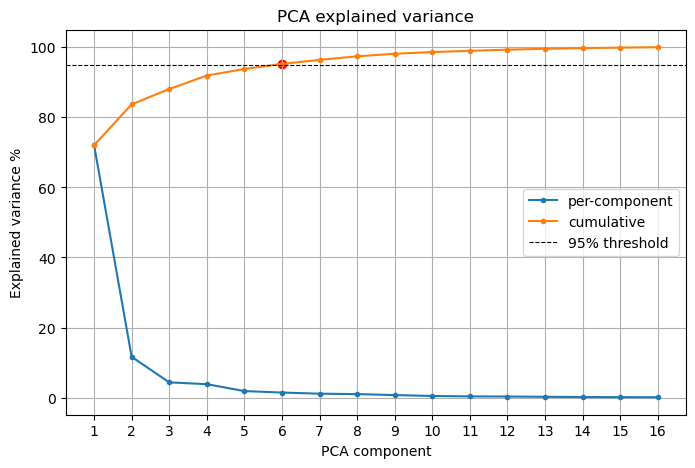

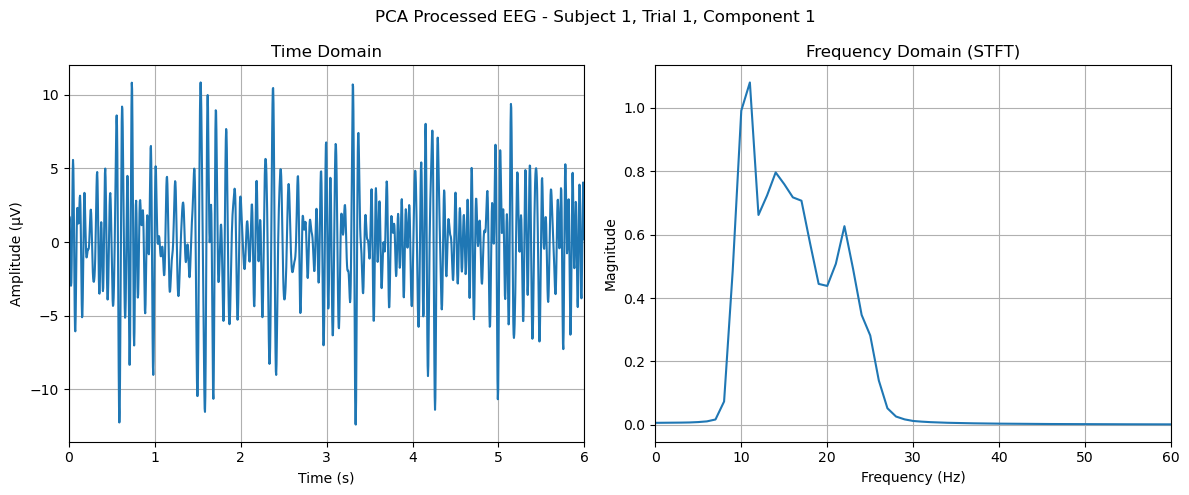

In [10]:
def plot_pca_explained(pca, threshold=95):
    explained = pca.explained_variance_ratio_ * 100
    cum = np.cumsum(explained)
    comps = np.arange(1, len(explained) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(comps, explained, marker='o', markersize=3, label='per-component')
    plt.plot(comps, cum, marker='o', markersize=3, label='cumulative')
    plt.axhline(threshold, color='k', linestyle='--', linewidth=0.8, label=f'{threshold}% threshold')

    n_comp = np.searchsorted(cum, threshold) + 1
    plt.scatter(n_comp, cum[n_comp-1], color='r')
    plt.xlabel('PCA component')
    plt.xticks(np.arange(1, len(explained)+1))
    plt.ylabel('Explained variance %')
    plt.title('PCA explained variance')
    plt.grid(True)
    plt.legend()
    plt.show()

n_components = plot_pca_explained(pca)
plot_EEG_channel(X_pca[0, 0, :, 0], fs, "PCA Processed EEG - Subject 1, Trial 1, Component 1")

## CSP

In [11]:
from scipy.linalg import eigh

def covariance_matrix(trial):
    # trial: (channels, samples)
    C = trial @ trial.T
    return C / np.trace(C)

def fit_csp(X, y):
    """
    X: (n_trials, n_channels, n_samples)
    y: (n_trials,)
    returns: W (n_channels, n_channels)
    """

    cov_0 = []
    cov_1 = []

    for i in range(len(y)):
        C = covariance_matrix(X[i])
        if y[i] == 0:
            cov_0.append(C)
        else:
            cov_1.append(C)

    C0 = np.mean(cov_0, axis=0)
    C1 = np.mean(cov_1, axis=0)

    # Solve generalized eigenvalue problem
    eigvals, eigvecs = eigh(C0, C0 + C1)

    # Sort descending
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]

    return eigvecs.T  # spatial filters

def apply_csp(W, X, k):
    """
    W: (channels, channels)
    X: (n_trials, channels, samples)
    k: number of components PER CLASS

    returns:
    X_csp: (n_trials, 2k, samples)
    """

    # Select first k and last k filters
    W_sel = np.vstack([
        W[:k, :],     # maximize class 0
        W[-k:, :]     # maximize class 1
    ])  # (2k, channels)

    n_trials, n_channels, n_samples = X.shape
    n_components = W_sel.shape[0]

    X_csp = np.zeros((n_trials, n_components, n_samples))

    for i in range(n_trials):
        X_csp[i] = W_sel @ X[i]   # (components, samples)

    return X_csp.transpose(0, 2, 1)

n_subjects, n_trials, n_samples, n_channels = EEG_filtered.shape
k = 3  # 3 per class → 6 CSP components

# Final CSP output: (subjects, trials, samples, components)
X_csp = np.zeros((n_subjects, n_trials, n_samples, 2 * k))

for s in range(n_subjects):
    # (trials, channels, samples)
    X_subj = EEG_filtered[s].transpose(0, 2, 1)
    # Per-subject normalization
    # X_subj = (X_subj.reshape(-1, n_channels) - means[s]) / stds[s]
    # X_subj = X_subj.reshape(n_trials, n_samples, n_channels)
    y_subj = y[s]

    W = fit_csp(X_subj, y_subj)
    X_csp[s] = apply_csp(W, X_subj, k)

print("CSP output shape:", X_csp.shape)


CSP output shape: (6, 434, 1536, 6)


## Plot CSP filtering effect
Since the goal is just dimensionality reduction, we expected the plots to be similar as before. Unlike [PCA](#plot-pca-filtering-effect), this looks dissimilar, though.

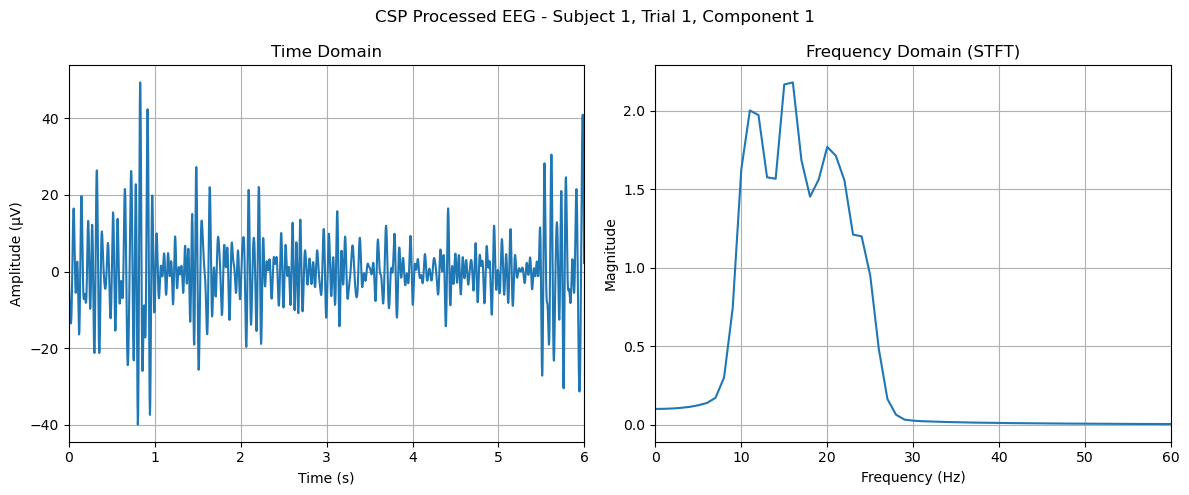

In [12]:
plot_EEG_channel(X_csp[0, 0, :, 0], fs, "CSP Processed EEG - Subject 1, Trial 1, Component 1")

# Power Spectrum Analysis
⚠️ From now on, only **CSP** data is used

## Fourier transformation (STFT)
Time domain -> Frequency domain

In [13]:
# STFT over time -> freq bins per component, mean over time
f_stft, t_stft, Z = signal.stft(X_csp, fs=fs, axis=2)
X_stft = np.abs(Z).mean(-1)  # (subjects, trials, freqs, comps)
X_stft.shape

(6, 434, 129, 6)

## Band Magnitude

In [14]:
bands = {
    "delta": (0.5,4), 
    "theta": (4,8), 
    "alpha": (8,13), 
    "beta":  (13,30), 
    "gamma": (30,45)
}

X_mag = np.zeros((n_subjects, n_trials, len(bands), X_stft.shape[-1]))  # (subj, trials, bands, comps)
for b, (lo, hi) in enumerate(bands.values()):
    idx = (f_stft >= lo) & (f_stft < hi)
    X_mag[:, :, b, :] = np.log(X_stft[:, :, idx, :]).sum(2)  # sum magnitude over band freqs (log-scaled)
print(X_mag.shape)  # (subjects, trials, bands, comps) -> magnitude

(6, 434, 5, 6)


Extract Mu and Beta only

In [15]:
alpha_idx, beta_idx = 2, 3  # from bands dict
X_mag = X_mag[:, :, [alpha_idx, beta_idx], :]  # (subj, trials, 2 bands, comps)
print(X_mag.shape)

(6, 434, 2, 6)


# Save to Pickle files
Exports the `.p` files for the [classification notebook](classification.ipynb).

In [16]:
import pickle 

# For band-power data
with open('preprocessed.p', 'wb') as f:
    print("Saving preprocessed.p as shape:", X_mag.shape)
    pickle.dump((X_mag, y), f)

# For time-series data
with open('preprocessed-ts.p', 'wb') as f:
    print("Saving preprocessed-ts.p as shape:", X_csp.shape)
    pickle.dump((X_csp, y), f)

Saving preprocessed.p as shape: (6, 434, 2, 6)
Saving preprocessed-ts.p as shape: (6, 434, 1536, 6)
